In [22]:
import pandas as pd
import pedpy
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import os
from typing import Tuple

import numpy.typing as npt
import pandas
from scipy.spatial.distance import cdist

from pedpy.column_identifier import FRAME_COL, ID_COL, X_COL, Y_COL
from scipy.signal import find_peaks
from matplotlib.patches import FancyArrowPatch, ArrowStyle
from matplotlib.ticker import FormatStrFormatter
import warnings

In [23]:
def extract_category_from_filename(filename: str) -> str:
    """
    Extracts the category part from a given filename, taking into account
    special cases like 'mix_sorted' and 'mix_random'.

    The category is extracted based on its position in the filename, which is
    assumed to follow the pattern: '../data/country/category_restOfTheFilename.csv'.

    Parameters:
    - filename (str): The full path of the file.

    Returns:
    - str: The extracted category.
    """
    # Extract the basename of the file (e.g., 'female_41_21.csv')
    basename = os.path.basename(filename)

    # Split by underscores and reconstruct the category part
    parts = basename.split('_')
    if parts[0].startswith("mix"):
        # Handles 'mix_sorted' and 'mix_random'
        category = "_".join(parts[:2])
    else:
        # Handles 'female', 'male', etc.
        category = parts[0]

    return category

In [24]:
@dataclass
class CategoryInfo:
    country: str
    category: str
    max_number: int
    max_number_filename: str
    min_number: int
    min_number_filename: str


def get_category_info(
    country: str, category: str, files: dict
) -> CategoryInfo:
    max_number = None
    min_number = None
    max_number_filename = None
    min_number_filename = None

    for filename in files[country]:
        gender = extract_category_from_filename(filename)
        if category == gender:
            current_number = int(filename.split("_")[-2])
            if max_number is None or current_number > max_number:
                max_number = current_number
                max_number_filename = filename

            if min_number is None or current_number < min_number:
                min_number = current_number
                min_number_filename = filename

    return CategoryInfo(
        country=country,
        category=category,
        max_number=max_number,
        max_number_filename=max_number_filename,
        min_number=min_number,
        min_number_filename=min_number_filename,
    )

In [25]:
# load_file and constants
categories = ["female", "male", "mix_sorted", "mix_random"]
colors = {
    "aus": "blue",
    "ger": "black",
    "jap": "orange",
    "chn": "red",
    "pal": "green",
}
max_radius = 2
max_g = 3

x_from = 0
x_to = 9
y_from = -3
y_to = 3
rename_mapping = {
    "ID": "id",
    "t(s)": "time",
    "x(m)": "x",
    "y(m)": "y",
}
column_types = {
    "id": int,
    "gender": int,
    "time": float,
    "x": float,
    "y": float,
}
countries = [
    "aus",
    "ger",
    "jap",
    "chn",
    "pal",
]
# files = {}
# for country in countries:
#     files[country] = glob.glob(f"../data/linear/{country}/*.csv")
#     #files[country] = glob.glob(f"../data/{country}/*.csv")


def load_file(filename: str, onfilter: bool = False) -> pedpy.TrajectoryData:
    def calculate_fps(data: pd.DataFrame) -> int:
        """Calculate fps based on the mean difference of the 'time' column."""
        mean_diff = data.groupby("id")["time"].diff().dropna().mean()
        return int(round(1 / mean_diff))

    def set_column_types(data: pd.DataFrame, col_types) -> pd.DataFrame:
        """Set the types of the dataframe columns based on the given column types."""
        # Ensure columns are in data before type casting
        valid_types = {
            col: dtype for col, dtype in col_types.items() if col in data.columns
        }
        return data.astype(valid_types)

    data = pd.read_csv(filename)

    data.rename(columns=rename_mapping, inplace=True)

    data = set_column_types(data, column_types)

    fps = calculate_fps(data)
    if onfilter:
        data = data[
            (data["x"] > x_from)
            & (data["x"] < x_to)
           # & (data["y"] > y_from)
           # & (data["y"] < y_to)
        ].dropna()

    return pedpy.TrajectoryData(data=data, frame_rate=fps)

In [26]:
# def compute_pair_distibution_function(*, traj_data: pandas.DataFrame, radius_bin_size: float, method='dist') -> Tuple[npt.NDArray[np.float16], npt.NDArray[np.float16]]:
#     """
#     Computes the pair distribution function g(r) for a given set of trajectory data.

#     This function calculates the spatial distribution of positions :math:`g(r)`
#     For a variable :math:`r`, the pdf is given by the probability that two pedestrians are separated
#     by :math:`r` normalized by the probability :math:`PNI(r)` that two non-interacting pedestrians
#     are separated by :math:`r`, specifically

#     .. math::
#         g(r) = P(r)/PNI(r),

#     Args:
#     - traj_data: TrajectoryData, an object containing the trajectories.
#     - radius_bin_size: float, the size of the bins for the radial distribution function in the same units as the positions.

#     Returns:
#     - Tuple[np.ndarray, np.ndarray]: A tuple of two numpy arrays. The first array contains the bin edges (excluding the first bin edge),
#       and the second array contains the values of the pair distribution function :math:`g(r)` for each bin.
#     """

#     df = traj_data.dropna(subset=["frame"])
#     # Create Dataframe with all mutual distances
#     if method == 'dist':
#         dist_pd_array = calculate_data_frame_pair_dist(df)
#     if method == 'gender':
#         dist_pd_array = calculate_data_frame_pair_dist_diff_gender(df)

#     # Scramble time-information to mitigate finite-size effects and calculate mutual distances of scrambled dataset
#     df.loc[:, FRAME_COL] = df.frame.sample(frac=1).reset_index(drop=True).astype('int64')

#     if method == 'dist':
#         dist_pd_ni_array = calculate_data_frame_pair_dist(df)
#     if method == 'gender':
#         dist_pd_ni_array = calculate_data_frame_pair_dist_diff_gender(df)

#     ## Create the bin for data
#     radius_bins = np.arange(0, dist_pd_array.max(), radius_bin_size)

#     # Calculate pair distibution: g(r)
#     Nb_dist = len(dist_pd_array)
#     ## Actual distribution
#     pd_bins = pandas.cut(dist_pd_array, radius_bins)
#     pd_bins_normalised = (pd_bins.value_counts().sort_index().to_numpy()) / Nb_dist
#     ## Scrambled distribution
#     pd_ni_bins = pandas.cut(dist_pd_ni_array, radius_bins)
#     pd_ni_bins_normalised = (pd_ni_bins.value_counts().sort_index().to_numpy()) / Nb_dist

#     # pd_ni_bins_normalised deal with the possibility of division by zero
#     # pair_distribution = pd_bins_normalised / pd_ni_bins_normalised
#     # Handle division by zero: specify 'out' to define the output array, and 'where' to conditionally perform division
#     pair_distribution = np.divide(pd_bins_normalised, pd_ni_bins_normalised, out=np.zeros_like(pd_bins_normalised), where=pd_ni_bins_normalised != 0)

#     return radius_bins[1:], pair_distribution

def calculate_data_frame_pair_dist_diff_gender(
    df: pandas.DataFrame,
    male_identifier: int = 2,
    female_identifier: int = 1,
) -> npt.NDArray[np.float16]:
    distances_list = []
    GENDER_COL = 'gender'
    for _, frame_df in df.groupby(FRAME_COL):
        male_df = frame_df[frame_df[GENDER_COL] == male_identifier]
        female_df = frame_df[frame_df[GENDER_COL] == female_identifier]

        if not male_df.empty and not female_df.empty:
            male_coordinates = male_df[[X_COL, Y_COL]].values
            female_coordinates = female_df[[X_COL, Y_COL]].values

            # Calculate pairwise distances from each male to each female in the current frame
            frame_distances = cdist(male_coordinates, female_coordinates, metric="euclidean")

            # Since we're only interested in male to female distances, no need to extract upper triangle
            distances_list.extend(frame_distances.flatten())

    return np.array(distances_list)

def calculate_data_frame_pair_dist(
    df: pandas.DataFrame,
) -> npt.NDArray[np.float16]:
    distances_list = []
    for _, frame_df in df.groupby(FRAME_COL):
        unique_ids = frame_df[ID_COL].unique()
        N_ids = len(unique_ids)
        if N_ids > 1:
            x_values = frame_df[X_COL].values
            y_values = frame_df[Y_COL].values
            #x_values =   np.zeros_like(x_values)
            #y_values =   np.zeros_like(x_values)
            coordinates = np.stack((x_values, y_values), axis=-1)
            # Calculate pairwise distances for the current frame using cdist
            frame_distances = cdist(coordinates, coordinates, metric="euclidean")#euclidean

            # Extract the upper triangle without the diagonal
            distances_upper_triangle = frame_distances[np.triu_indices_from(frame_distances, k=1)]

            distances_list.extend(distances_upper_triangle)

    return np.array(distances_list)


In [27]:
def compute_pair_distibution_function_new(
    *,
    traj_data: pd.DataFrame,
    radius_bin_size: float,
    randomisation_stacking: int = 1,
) -> Tuple[npt.NDArray[np.float16], npt.NDArray[np.float16]]:
    """Computes the pair distribution function g(r) for a given set of trajectory data.

    This function calculates the spatial distribution of positions :math:`g(r)`
    :math:`g(r)` here referred to the Euclidean distance between agents.
    The pdf is given by the probability that two pedestrians are separated
    by :math:`r` normalized by the probability :math:`PNI(r)` that two non-interacting pedestrians
    are separated by :math:`r`, specifically

    .. math::
        g(r) = P(r)/PNI(r),

    Args:
        traj_data: TrajectoryData, an object containing the trajectories.
        radius_bin_size: float, the size of the bins for the radial distribution function in the
            same units as the positions.
        randomisation_stacking: int, Number of time the dataset will be stacked before being
            randomly shuffled to exact distances of non-interacting pedestrians. Larger stacking
            number will lead to closer approximation of true pairwise distribution of non-
            interacting pedestrians but with also increase computation cost.


    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple of two numpy arrays. The first array contains the
            bin edges (excluding the first bin edge), and the second array contains the values of
            the pair-distribution function :math:`g(r)` for each bin.
    """
    data_df = traj_data

    # Create Dataframe with all pairwise distances
    pairwise_dist_array = calculate_data_frame_pair_dist(data_df)

    # Concatenate the working dataframe (data_df) to match the number of randomization cycles
    concatenated_random_df = pandas.concat(
        [data_df] * randomisation_stacking, ignore_index=True
    )
    # Scramble time-information to mitigate finite-size effects and calculate
    # pairwise distances of scrambled dataset
    concatenated_random_df.frame = concatenated_random_df.frame.sample(
        frac=1
    ).reset_index(drop=True)
    pairwise_dist_ni_array = calculate_data_frame_pair_dist(concatenated_random_df)

    ## Create the bin for data
    radius_bins = np.arange(0, pairwise_dist_array.max(), radius_bin_size)

    # Calculate pair distibution: g(r)
    ## Actual distribution
    pd_bins = pandas.cut(pairwise_dist_array, radius_bins)
    pd_bins_normalised = (pd_bins.value_counts().sort_index().to_numpy()) / len(
        pairwise_dist_array
    )  # Normalising by the number of pairwise distances in the dataframe
    ## Scrambled distribution
    pd_ni_bins = pandas.cut(pairwise_dist_ni_array, radius_bins)
    pd_ni_bins_normalised = (
        pd_ni_bins.value_counts().sort_index().to_numpy()
    ) / len(
        pairwise_dist_ni_array
    )  # Normalising by the number of pairwise distances in the dataframe

    # Suppress warnings
    warnings.filterwarnings("ignore")

    try:
        with np.errstate(divide="raise"):
            pair_distribution = pd_bins_normalised / pd_ni_bins_normalised
        warnings.filterwarnings("default")  # reset warning-values

    except FloatingPointError:
        warnings.filterwarnings("default")  # reset warning-values
        pair_distribution = pd_bins_normalised / pd_ni_bins_normalised
        warning_message = (
            "Random probability distribution contains null values,"
            + "try using larger dx or more randomization cycles."
        )
        warnings.warn(warning_message)

    return radius_bins[1:], pair_distribution

## Plot per category at specific densities for categories

according to hard-coded files. 
concatenate more similar runs in one df

In [28]:
linear = False
high_density = False
# Define a function to load and concatenate trajectory data
def load_and_concatenate(country, category):
    # high density
    if high_density:
        country_file_mapping = {
            'ger': {
                'female': {
                    'filenames': ['female_36_01.csv'],
                    'method': 'dist',
                    'num': 36,
                },
                'male': {
                    'filenames': ['male_35_01.csv'],
                    'method': 'dist',
                    'num': 35,
                },
                'mix_sorted': {
                    'filenames': ['mix_sorted_36_01.csv'],
                    'method': 'dist',
                    'num': 36,
                },
                'mix_random': {
                    'filenames': ['mix_random_36_01.csv'],
                    'method': 'dist',
                    'num': 36,
                },
            },
            'aus': {
                'mix_random': {
                    'filenames': ['mix_random_41_01.csv', 'mix_random_42_01.csv'],
                    'method': 'dist',
                    'num': 41,
                },
                'mix_sorted': {
                    'filenames': ['mix_sorted_40_01.csv', 'mix_sorted_41_01.csv'],
                    'method': 'dist',
                    'num': 40,
                },
            },
            'jap': {
                'female': {
                    'filenames': ['female_40_01.csv'],
                    'method': 'dist',
                    'num': 40,
                },
                'male': {
                    'filenames': ['male_40_01.csv'],
                    'method': 'dist',
                    'num': 40,
                },
                'mix_random': {
                    'filenames': ['mix_random_40_01.csv', 'mix_random_40_02.csv'],
                    'method': 'dist',
                    'num': 40,
                },
            },
            'chn': {
                'female': {
                    'filenames': ['female_40_01.csv'],
                    'method': 'dist',
                    'num': 40,
                },
                'male': {
                    'filenames': ['male_40_01.csv'],
                    'method': 'dist',
                    'num': 40,
                },
                'mix_sorted': {
                    'filenames': ['mix_sorted_40_01.csv'],
                    'method': 'dist',
                    'num': 40,
                },
                'mix_random': {
                    'filenames': ['mix_random_40_01.csv'],
                    'method': 'dist',
                    'num': 40,
                },

            },
            'pal': {
                'mix_sorted': {
                    'filenames': ['mix_sorted_30_01.csv', 'mix_sorted_30_02.csv'],
                    'method': 'dist',
                    'num': 30,
                },
            },
        }
    # low density
    if not high_density:
        country_file_mapping = {
            'ger': {
                'female': {
                    'filenames': ['female_20_02.csv', 'female_20_01.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'male': {
                    'filenames': ['male_20_01.csv', 'male_19_01.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'mix_sorted': {
                    'filenames': ['mix_sorted_20_01.csv', 'mix_sorted_20_02.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'mix_random': {
                    'filenames': ['mix_random_20_01.csv', 'mix_random_20_02.csv'],
                    'method': 'dist',
                    'num': 20,
                },
            },
            'aus': {
                'female': {
                    'filenames': ['female_21_01.csv', 'female_22_01.csv'],
                    'method': 'dist',
                    'num': 21,
                },
                'male': {
                    'filenames': ['male_20_01.csv', 'male_21_01.csv'],
                    'method': 'dist',
                    'num': 20,
                },
            },
            'jap': {
                'female': {
                    'filenames': ['female_16_01.csv', 'female_16_02.csv', 'female_24_01.csv', 'female_24_01.csv'],
                    'method': 'dist',
                    'num': 16,
                },
                'male': {
                    'filenames': ['male_16_01.csv', 'male_16_02.csv', 'male_24_01.csv', 'male_24_01.csv'],
                    'method': 'dist',
                    'num': 16,
                },
                'mix_random': {
                    'filenames': ['mix_random_16_01.csv', 'mix_random_16_02.csv', 'mix_random_24_01.csv', 'mix_random_24_02.csv'],
                    'method': 'dist',
                    'num': 16,
                },
                #-----
            },
            'chn': {
                'female': {
                    'filenames': ['female_20_01.csv', 'female_20_02.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'male': {
                    'filenames': ['male_20_01.csv', 'male_20_02.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'mix_sorted': {
                    'filenames': ['mix_sorted_20_01.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'mix_random': {
                    'filenames': ['mix_random_20_01.csv'],
                    'method': 'dist',
                    'num': 20,
                },

            },
            'pal': {
                'female': {
                    'filenames': ['female_20_01.csv', 'female_20_02.csv', 'female_20_03.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'male': {
                    'filenames': ['male_20_01.csv', 'male_20_02.csv'],
                    'method': 'dist',
                    'num': 20,
                },
                'mix_sorted': {
                    'filenames': ['mix_sorted_20_01.csv', 'mix_sorted_20_02.csv', 'mix_sorted_20_03.csv', 'mix_sorted_20_04.csv'],
                    'method': 'dist',
                    'num': 20,
                },
            },
        }

    # Check if the country and category are in the mapping
    if country in country_file_mapping and category in country_file_mapping[country]:
        files_info = country_file_mapping[country][category]
        if linear:
            paths = [f'../data/linear/{country}/{filename}' for filename in files_info['filenames']]
        else:
            paths = [f'../data/{country}/{filename}' for filename in files_info['filenames']]

        method = files_info['method']
        num = files_info['num']
        # Load and concatenate data for the given file paths
        data_frames = [load_file(path).data for path in paths]
        df_concatenated = pd.concat(data_frames, axis=0).reset_index(drop=True)
        return df_concatenated, method, num

    print(f"Country ({country}) or category ({category}) not found in the file mapping. Continue!!")
    return pandas.DataFrame(), "", -1

In [29]:
def plot_category(
    country,
    category,
    yoffset=0.5,
    yhight=0.5,
    ylim=4,
    xmin=-0.1,
    xlim=2,
    firstpeak=0,
    secondpeak=1,
    min_hight_peaks=1,
    randomisation_stacking=5
):
    """
    Plots a figure for one category across all countries focusing on minimum or maximum values.
    """

    df_concatenated, method, num = load_and_concatenate(country, category)
    if num == -1:
        return np.nan, np.nan, np.nan
    fig, ax = plt.subplots(figsize=(5, 5))
    radius_bins, pair_distribution = compute_pair_distibution_function_new(
        traj_data=df_concatenated, radius_bin_size=0.1, randomisation_stacking=randomisation_stacking
    )
    ax.plot(
        radius_bins,
        pair_distribution,
        linewidth=1.3,
        label=f"{country}, N={num}",
        color="gray",
        zorder=1,
    )  # colors[country]
    peaks, _ = find_peaks(pair_distribution, height=min_hight_peaks)
    #peak_heights = properties["peak_heights"]
    #if peak_heights[0] < peak_heights[1]:
    #    peaks = peaks[1:]
    #    peak_heights = peak_heights[1:]

    r_peaks = radius_bins[peaks]
    peak_distances = np.diff(r_peaks)
    peak_heights = pair_distribution[peaks]
    #ax.scatter(r_peaks, peak_heights, color="gray", zorder=2)
    ax.scatter(r_peaks, pair_distribution[peaks], color="gray", zorder=2)
    for i, (r_peak, g_peak) in enumerate(zip(r_peaks, peak_heights)):
        ax.plot(
            [r_peak, r_peak],
            [0, g_peak],
            color="gray",
            linestyle="--",
            zorder=3,
            alpha=0.05,
        )
        if i == firstpeak or i == secondpeak:
            ax.annotate(
                f"{r_peak:.2f} m",  # (f'({r_peak:.2f}, {g_peak:.2f})',
                xy=(r_peak, g_peak),
                xytext=(r_peak, g_peak + yoffset),  # Slight offset for the annotation
                arrowprops = {"facecolor": "black", "shrink": 0.05, "width": 1, "headwidth": 8},
                fontsize=9,
                textcoords="data",
                ha="center",
            )

    # horizontal arrow
    x_start = r_peaks[firstpeak]
    x_end = r_peaks[secondpeak]
    y_position = min(peak_heights[:2]) - yhight
    arrow_style = ArrowStyle("fancy", head_length=2, head_width=1.5)
    arrow = FancyArrowPatch(
        (x_start, y_position),
        (x_end, y_position),
        arrowstyle=arrow_style,
        mutation_scale=3,
        color="black",
        lw=1,
    )

    # Add the arrow to the plot
    ax.add_patch(arrow)
    arrow = FancyArrowPatch(
        (x_end, y_position),
        (x_start, y_position),
        arrowstyle=arrow_style,
        mutation_scale=3,
        color="black",
        lw=1,
    )

    # Add the arrow to the plot
    ax.add_patch(arrow)

    # add text indicating the distance between the two peaks
    distance = x_end - x_start
    ax.text(
        (x_start + x_end) / 2,
        y_position - 0.07,
        f"{distance:.2f} m",
        ha="center",
        va="top",
        fontsize=9,
    )
    print(f"{country}, {category}: {r_peaks = }, {peak_distances = }")

    ax.set_xlabel(r"$r\; /\; m$", fontsize=14)
    ax.set_ylabel(r"$g(r)$", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.set_xlim([xmin, xlim])  # aus: 2
    ax.set_ylim([0, ylim])
    # ax.set_title(f"{country}_{category}_method_{method}_num_{num}", fontsize=14)
    ax.legend(fontsize=14)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    if linear:
        fignames = [
            f"lin_category/pdf/lin_{country}_{category}_method_{method}_num_{num}.pdf",
            f"lin_category/png/lin_{country}_{category}_method_{method}_num_{num}.png",
        ]
    else:
        fignames = [
            f"category/pdf/{country}_{category}_method_{method}_num_{num}.pdf",
            f"category/png/{country}_{category}_method_{method}_num_{num}.png",
        ]

    for figname in fignames:
        plt.savefig(figname, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"return with {r_peaks[0] = }, {peak_heights[0] = }, {peak_distances[0] =}    ")
    return r_peaks[0], peak_heights[0], peak_distances[0]

In [30]:
# df_concatenated, method, num = load_and_concatenate("pal", "female")
# radius_bins, pair_distribution = compute_pair_distibution_function_new(
#     traj_data=df_concatenated, radius_bin_size=0.1, randomisation_stacking=5
# )
# #plt.plot(radius_bins, pair_distribution)
# min_h = 1
# peaks, properties = find_peaks(pair_distribution, height=min_h)
# r_peaks = radius_bins[peaks]
# plt.plot(radius_bins, pair_distribution)
# plt.plot(radius_bins[peaks], pair_distribution[peaks], "x")
# plt.plot([radius_bins[0], radius_bins[-1]], [min_h, min_h], "k-")
# print(pair_distribution[peaks][:2], "\n",pair_distribution[peaks][0]-pair_distribution[peaks][1])
# print(radius_bins[peaks][:2], "\n", radius_bins[peaks][1]- radius_bins[peaks][0])

## Palestine

In [31]:
# country = "pal"
# plot_category(
#     country,
#     "female",
#     yoffset=0.3,
#     yhight=1.1,
#     ylim=2.5,
#     xmin=0.2,
#     xlim=4,
#     min_hight_peaks=1.,
# )
# plot_category(
#     country, category="male", yoffset=0.2, yhight=0.25, ylim=2.5, xlim=3.5,
#     min_hight_peaks=1.,

# )
# plot_category(
#     country,
#     category="mix_sorted",
#     yoffset=0.4,
#     yhight=0.2,
#     ylim=2.5,
#     xlim=3.5,
#     min_hight_peaks=1.,

# )

## Japan

In [32]:
#country = 'jap'
#plot_category(country, 'female', yoffset=0.7, yhight=0.7, ylim=2.5, xlim=3)
#plot_category(country, category='male', yoffset=0.6, yhight=0.75, ylim=2.5, xlim=3)
#plot_category(country, category='mix_random', yoffset=0.4, yhight=0.6, ylim=2.5, xlim=3)

## Germany

In [33]:
# country = 'ger'
# plot_category(country, 'female', yoffset=0.5, yhight=0.6, ylim=2.5, xlim=3)
# plot_category(country, category='male', yoffset=0.5, yhight=0.4, ylim=2.5, xlim=3)
# plot_category(country, category='mix_random', yoffset=0.5, yhight=0.65, ylim=2.5, xlim=3)
# plot_category(country, category='mix_sorted', yoffset=0.5, yhight=0.95, ylim=2.5, xlim=3)

## Australia

In [34]:
# country = 'aus'
# plot_category(country, 'female', yoffset=0.7, yhight=0.45, ylim=2.5, xlim=3)
# plot_category(country, category='male', yoffset=0.7, yhight=0.4, ylim=2.5, xlim=3)
# plot_category(country, category='mix_sorted', yoffset=0.7, yhight=0.6, ylim=2.5, xlim=3)
# plot_category(country, category='mix_random', yoffset=0.7, yhight=0.2, ylim=2.5, xlim=3)

## China

In [35]:
# country = 'chn'
# plot_category(country, category='mix_sorted', yoffset=0.7, yhight=0.5, ylim=4, xlim=4)
# plot_category(country, category='mix_random', yoffset=0.7, yhight=0.35, ylim=3, xlim=4)
# plot_category(country, category='female', yoffset=0.7, yhight=0.35, ylim=3, xlim=4)
# plot_category(country, category='male', yoffset=0.7, yhight=0.35, ylim=3, xlim=4)

## Summary figure over all genders and/or countries

This cell produced a DatFrame for the rest of the cells

Country (aus) or category (mix_random) not found in the file mapping. Continue!!
Country (aus) or category (mix_sorted) not found in the file mapping. Continue!!
aus, male: r_peaks = array([0.7, 1.4, 2. , 2.5, 2.7, 3.2, 3.5, 4. , 4.3, 4.6, 4.9, 5.4]), peak_distances = array([0.7, 0.6, 0.5, 0.2, 0.5, 0.3, 0.5, 0.3, 0.3, 0.3, 0.5])


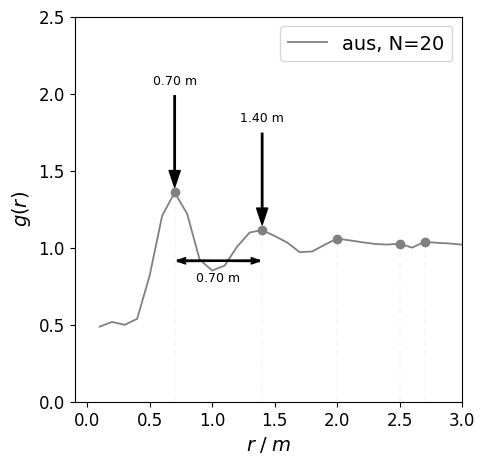

return with r_peaks[0] = 0.7000000000000001, peak_heights[0] = 1.358805157505743, peak_distances[0] =0.7000000000000001    
aus, female: r_peaks = array([0.7, 1.2, 1.7, 2.4, 3. , 3.4, 3.9, 4.4, 4.6, 4.8, 5.2, 5.4]), peak_distances = array([0.5, 0.5, 0.7, 0.6, 0.4, 0.5, 0.5, 0.2, 0.2, 0.4, 0.2])


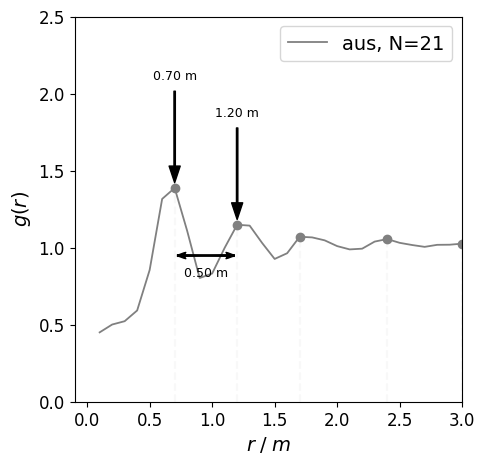

return with r_peaks[0] = 0.7000000000000001, peak_heights[0] = 1.3879650688770748, peak_distances[0] =0.5000000000000001    
chn, mix_random: r_peaks = array([0.8, 1.7, 2.5, 2.8, 3.1, 3.3, 3.6, 3.9, 4.1, 4.3, 4.6, 4.9, 5.1,
       5.3, 5.5, 5.9, 6.2, 6.4]), peak_distances = array([0.9, 0.8, 0.3, 0.3, 0.2, 0.3, 0.3, 0.2, 0.2, 0.3, 0.3, 0.2, 0.2,
       0.2, 0.4, 0.3, 0.2])


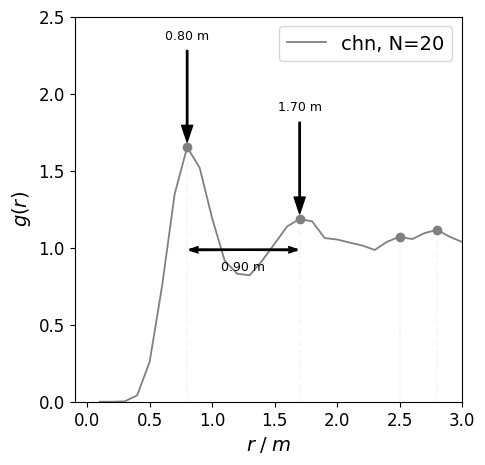

return with r_peaks[0] = 0.8, peak_heights[0] = 1.652289226632151, peak_distances[0] =0.9000000000000001    
chn, mix_sorted: r_peaks = array([0.8, 1.5, 2. , 2.3, 2.8, 3. , 3.5, 3.7, 4. , 4.3, 4.9, 5.2, 5.5,
       6. , 6.2]), peak_distances = array([0.7, 0.5, 0.3, 0.5, 0.2, 0.5, 0.2, 0.3, 0.3, 0.6, 0.3, 0.3, 0.5,
       0.2])


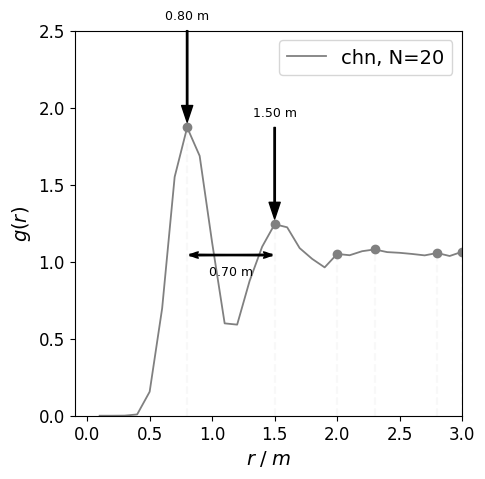

return with r_peaks[0] = 0.8, peak_heights[0] = 1.8719784226914309, peak_distances[0] =0.7    
chn, male: r_peaks = array([0.8, 1.6, 1.8, 2. , 2.3, 2.5, 3. , 3.6, 4.2, 4.6, 5.1, 5.5, 5.9,
       6.3]), peak_distances = array([0.8, 0.2, 0.2, 0.3, 0.2, 0.5, 0.6, 0.6, 0.4, 0.5, 0.4, 0.4, 0.4])


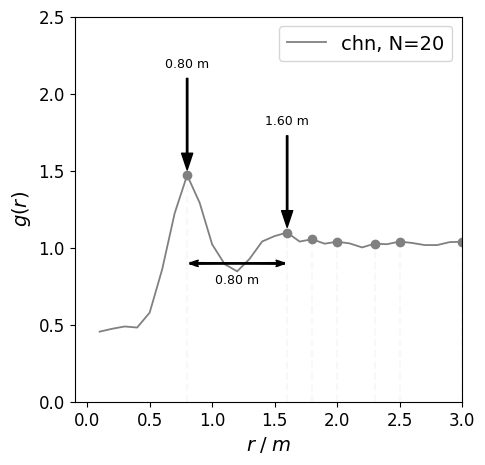

return with r_peaks[0] = 0.8, peak_heights[0] = 1.4712264234318833, peak_distances[0] =0.8    
chn, female: r_peaks = array([0.8, 1.8, 2.3, 2.5, 3.1, 3.5, 4. , 4.5, 4.7, 5.2, 5.4, 5.6, 5.9,
       6.3, 6.5]), peak_distances = array([1. , 0.5, 0.2, 0.6, 0.4, 0.5, 0.5, 0.2, 0.5, 0.2, 0.2, 0.3, 0.4,
       0.2])


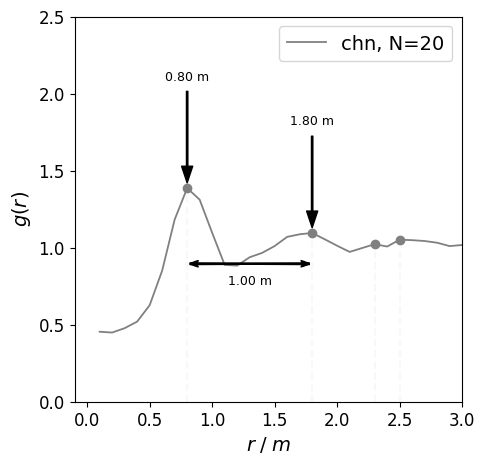

return with r_peaks[0] = 0.8, peak_heights[0] = 1.3869500293656338, peak_distances[0] =1.0    
jap, mix_random: r_peaks = array([0.7, 1.3, 1.9, 2.5, 2.8, 3.1, 3.3, 3.7, 4. , 4.3, 4.6, 5. , 5.2,
       5.5, 5.9]), peak_distances = array([0.6, 0.6, 0.6, 0.3, 0.3, 0.2, 0.4, 0.3, 0.3, 0.3, 0.4, 0.2, 0.3,
       0.4])


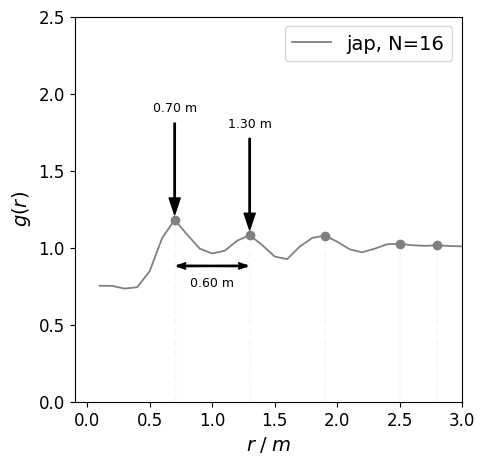

return with r_peaks[0] = 0.7000000000000001, peak_heights[0] = 1.180751602385187, peak_distances[0] =0.6    
Country (jap) or category (mix_sorted) not found in the file mapping. Continue!!
jap, male: r_peaks = array([0.7, 1.2, 1.8, 2.4, 3.1, 3.4, 3.7, 4.1, 4.3, 4.6, 5. , 5.4, 5.6]), peak_distances = array([0.5, 0.6, 0.6, 0.7, 0.3, 0.3, 0.4, 0.2, 0.3, 0.4, 0.4, 0.2])


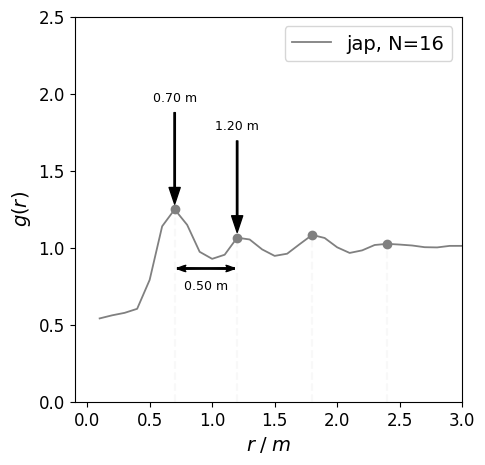

return with r_peaks[0] = 0.7000000000000001, peak_heights[0] = 1.2488347289725577, peak_distances[0] =0.5000000000000001    
jap, female: r_peaks = array([0.6, 1.2, 1.8, 2.4, 2.7, 3.1, 3.3, 3.6, 3.8, 4.3, 4.6, 5. , 5.2,
       5.4, 5.6]), peak_distances = array([0.6, 0.6, 0.6, 0.3, 0.4, 0.2, 0.3, 0.2, 0.5, 0.3, 0.4, 0.2, 0.2,
       0.2])


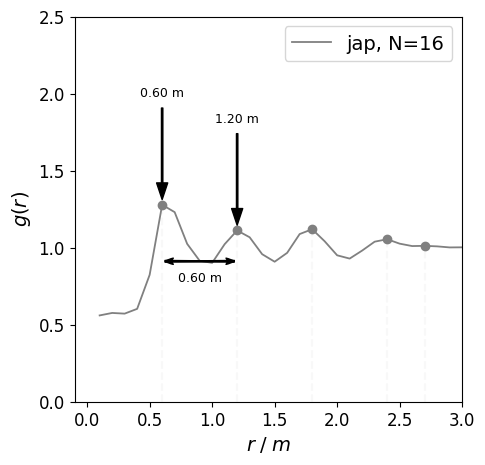

return with r_peaks[0] = 0.6000000000000001, peak_heights[0] = 1.278672795857872, peak_distances[0] =0.6000000000000001    
ger, mix_random: r_peaks = array([0.8, 1.5, 2.2, 2.8, 3.2, 3.8, 4.2, 4.7, 5. , 5.5, 5.8]), peak_distances = array([0.7, 0.7, 0.6, 0.4, 0.6, 0.4, 0.5, 0.3, 0.5, 0.3])


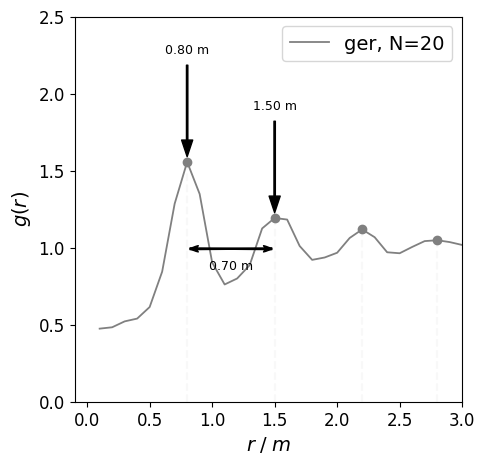

return with r_peaks[0] = 0.8, peak_heights[0] = 1.556912124304109, peak_distances[0] =0.7    
ger, mix_sorted: r_peaks = array([0.8, 1.5, 2. , 2.2, 2.4, 2.8, 3.1, 3.3, 3.6, 4. , 4.3, 4.6, 4.8,
       5.1, 5.5, 5.8]), peak_distances = array([0.7, 0.5, 0.2, 0.2, 0.4, 0.3, 0.2, 0.3, 0.4, 0.3, 0.3, 0.2, 0.3,
       0.4, 0.3])


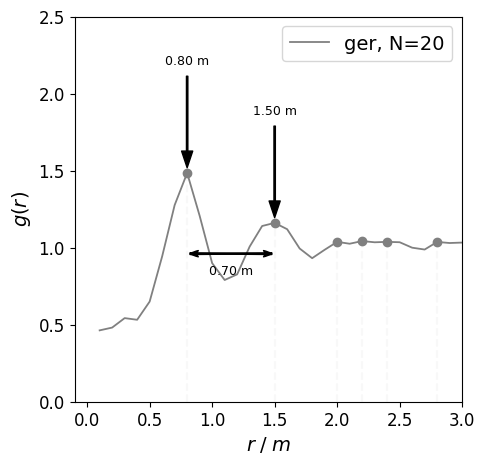

return with r_peaks[0] = 0.8, peak_heights[0] = 1.4852685617148287, peak_distances[0] =0.7    
ger, male: r_peaks = array([0.8, 1.6, 2.4, 3. , 3.2, 3.6, 3.8, 4.1, 4.5, 4.9, 5.2, 5.6]), peak_distances = array([0.8, 0.8, 0.6, 0.2, 0.4, 0.2, 0.3, 0.4, 0.4, 0.3, 0.4])


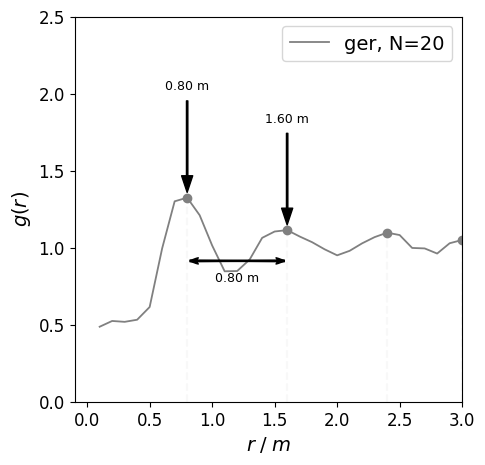

return with r_peaks[0] = 0.8, peak_heights[0] = 1.3250527529753777, peak_distances[0] =0.8    
ger, female: r_peaks = array([0.8, 1.5, 2.2, 2.6, 2.9, 3.3, 3.7, 4.1, 4.4, 4.7, 4.9, 5.1, 5.4,
       5.8]), peak_distances = array([0.7, 0.7, 0.4, 0.3, 0.4, 0.4, 0.4, 0.3, 0.3, 0.2, 0.2, 0.3, 0.4])


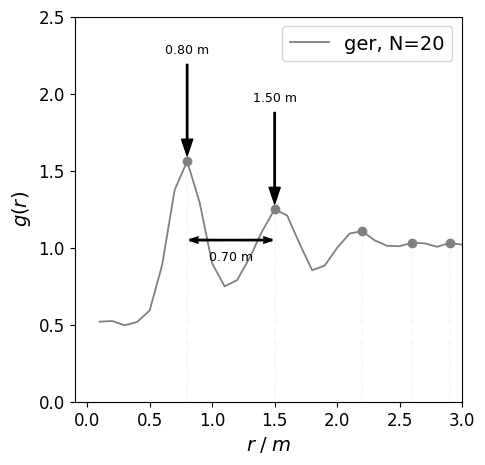

return with r_peaks[0] = 0.8, peak_heights[0] = 1.562248796903404, peak_distances[0] =0.7    
Country (pal) or category (mix_random) not found in the file mapping. Continue!!
pal, mix_sorted: r_peaks = array([0.9, 1.8, 2.3, 2.5, 2.8, 3.1, 3.5]), peak_distances = array([0.9, 0.5, 0.2, 0.3, 0.3, 0.4])


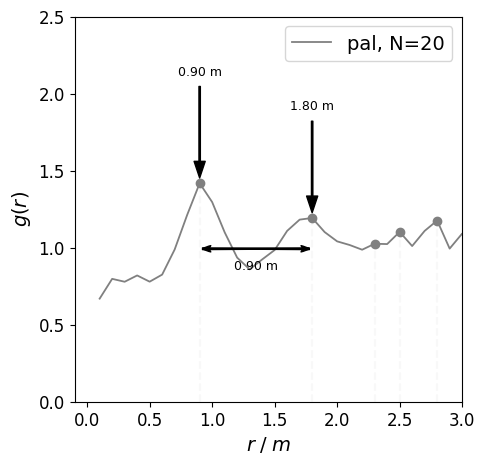

return with r_peaks[0] = 0.9, peak_heights[0] = 1.4186981841130097, peak_distances[0] =0.9    
pal, male: r_peaks = array([0.9, 1.7, 2.2, 2.5, 3.1, 3.4]), peak_distances = array([0.8, 0.5, 0.3, 0.6, 0.3])


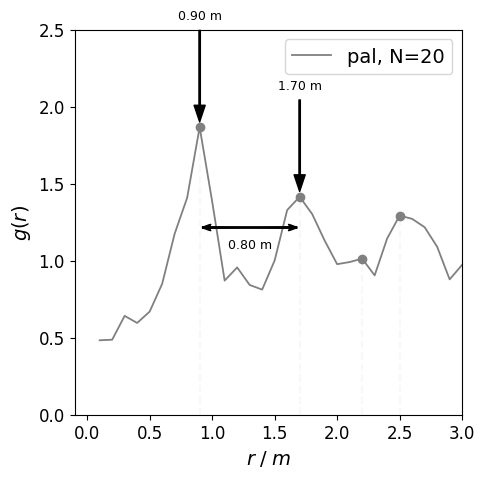

return with r_peaks[0] = 0.9, peak_heights[0] = 1.8671750724084824, peak_distances[0] =0.8000000000000002    
pal, female: r_peaks = array([0.9, 1.7, 2.6, 3.3]), peak_distances = array([0.8, 0.9, 0.7])


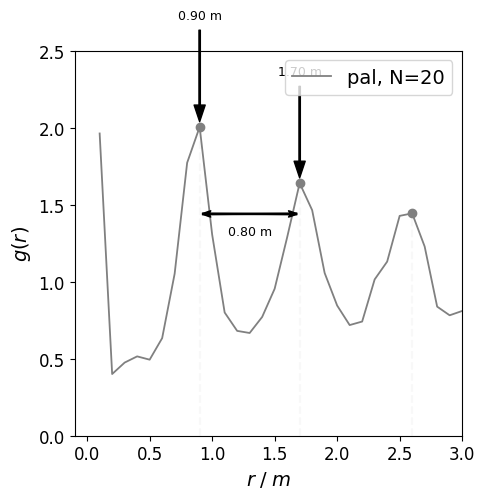

return with r_peaks[0] = 0.9, peak_heights[0] = 2.004944667660212, peak_distances[0] =0.8000000000000002    


In [36]:
# Define the parameters
categories = ['mix_random', 'mix_sorted', 'male', 'female']
countries = ['aus', 'chn', 'jap', 'ger', 'pal']
results = []

# Collect data
for country in countries:
    for category in categories:
        first_peak, first_height, distance = plot_category(country, category=category, yoffset=0.7, yhight=0.2, ylim=2.5, xlim=3)
        results.append({'country': country, 'category': category, 'first_peak': first_peak, 'first_height': first_height, 'distance': distance})

# Convert results to DataFrame
df = pd.DataFrame(results)

category/pdf/first_peak_vs_distance_mix_random_low.pdf
category/pdf/first_peak_vs_distance_mix_sorted_low.pdf
category/pdf/first_peak_vs_distance_male_low.pdf
category/pdf/first_peak_vs_distance_female_low.pdf


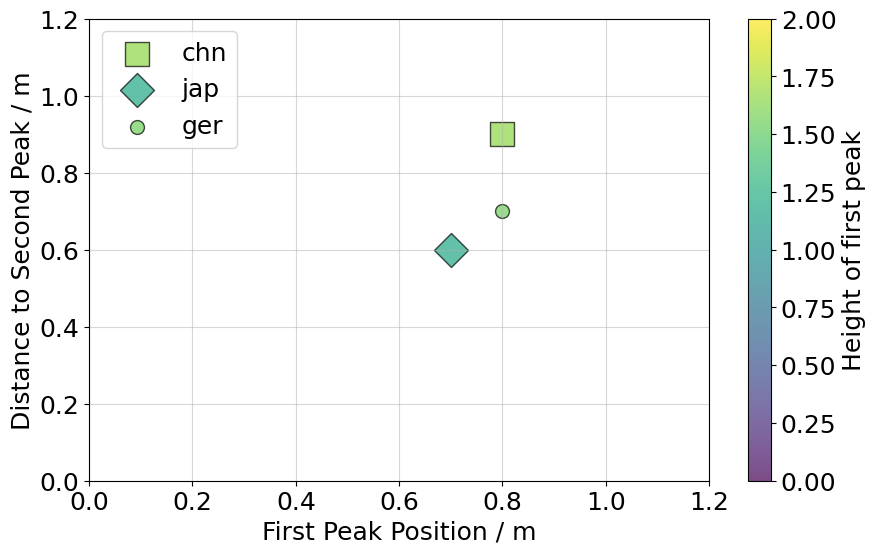

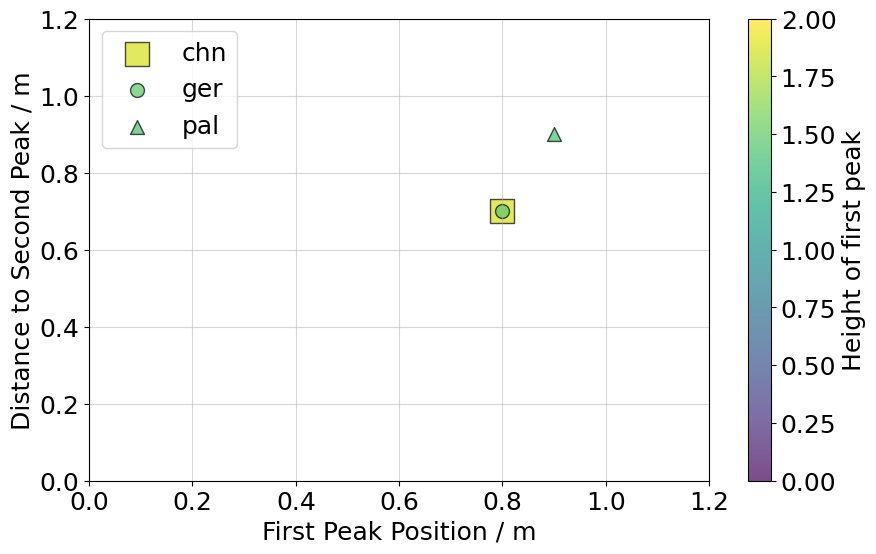

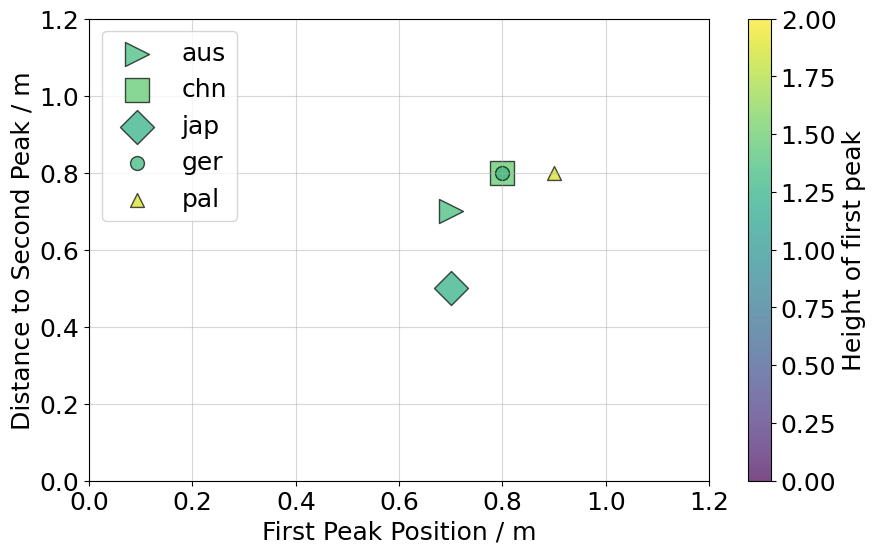

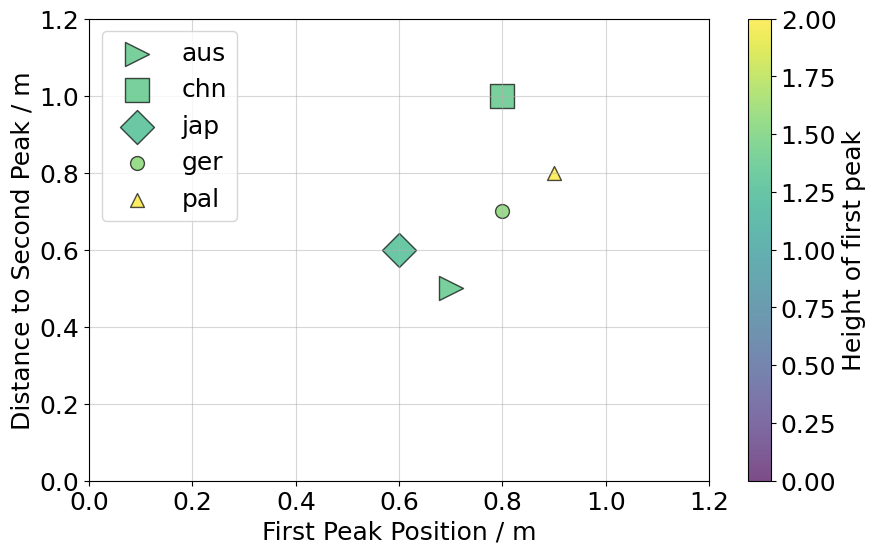

In [37]:
markers = ["o", "s", "^", "D", "+"]  # List of markers for different categories
markers = ["o", "s", "^", "D", "+"]
markers = [">", "s", "D", "o", "^"]
# Plot for each country
scatter_plots = []
first_height_min = df["first_height"].min()
first_height_max = df["first_height"].max()
unique_first_peaks = np.unique(df["first_peak"])
additional_ticks = [0, 0.2, 0.4, 0.6, 1.0, 1.2]
all_ticks = np.sort(np.unique(np.concatenate((unique_first_peaks, additional_ticks))))
for category in categories:
    plt.figure(figsize=(10, 6))
    for country, marker in zip(countries, markers):
        subset = df[(df["country"] == country) & (df["category"] == category)]
        #print(country, category, ">>",subset)
        if subset.empty or subset.isnull().values.any():
            continue
        if marker == "o" or marker == "^":
            mr_size = 100
        else:
            mr_size = 300
        scatter = plt.scatter(
            subset["first_peak"],
            subset["distance"],
            c=subset["first_height"],
            cmap="viridis",
            s=mr_size,
            label=country,
            marker=marker,
            facecolors="auto",
            edgecolors="black",
            alpha=0.7,
        )
        scatter.set_clim(0, 2)
        scatter_plots.append(scatter)
    cbar = plt.colorbar(scatter_plots[-1], label="First Height")
    cbar.set_label("Height of first peak", fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    # plt.title(f'First Peak vs Distance for {category}')
    plt.xlabel("First Peak Position / m", fontsize=18)
    plt.ylabel("Distance to Second Peak / m", fontsize=18)
    plt.legend(fontsize=18, loc="upper left")
    plt.grid(True, alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=18)
#    plt.xticks(all_ticks)
    plt.ylim([0, 1.2])
    plt.xlim([0, 1.2])

    if high_density:
        figname = f"category/pdf/first_peak_vs_distance_{category}_high.pdf"
    else:
        figname = f"category/pdf/first_peak_vs_distance_{category}_low.pdf"

    print(figname)
    plt.savefig(figname, dpi=300, bbox_inches="tight")

category/pdf/first_peak_vs_distance_mix_random_low.pdf
category/pdf/first_peak_vs_distance_mix_sorted_low.pdf
category/pdf/first_peak_vs_distance_male_low.pdf
category/pdf/first_peak_vs_distance_female_low.pdf


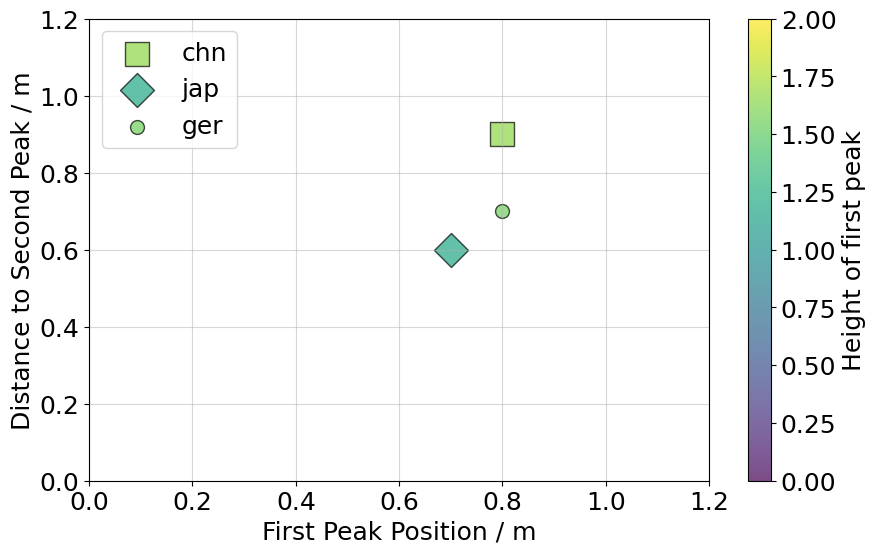

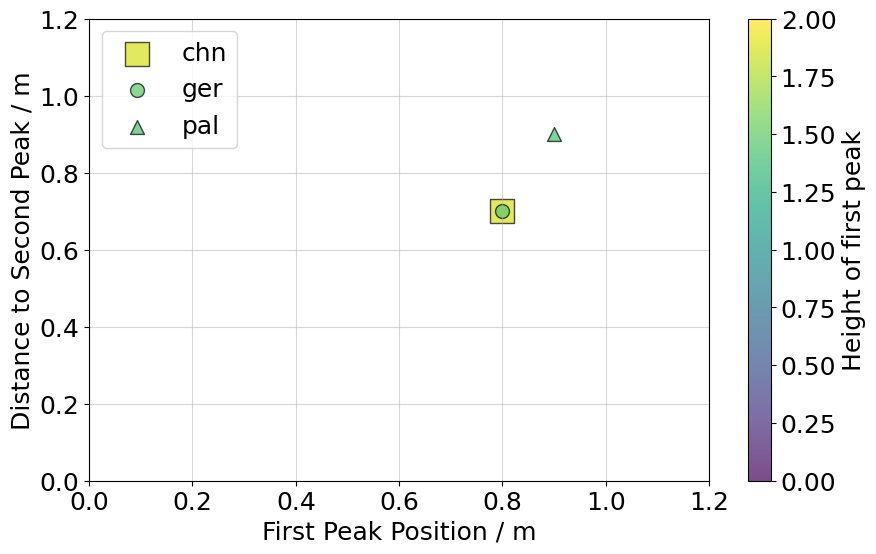

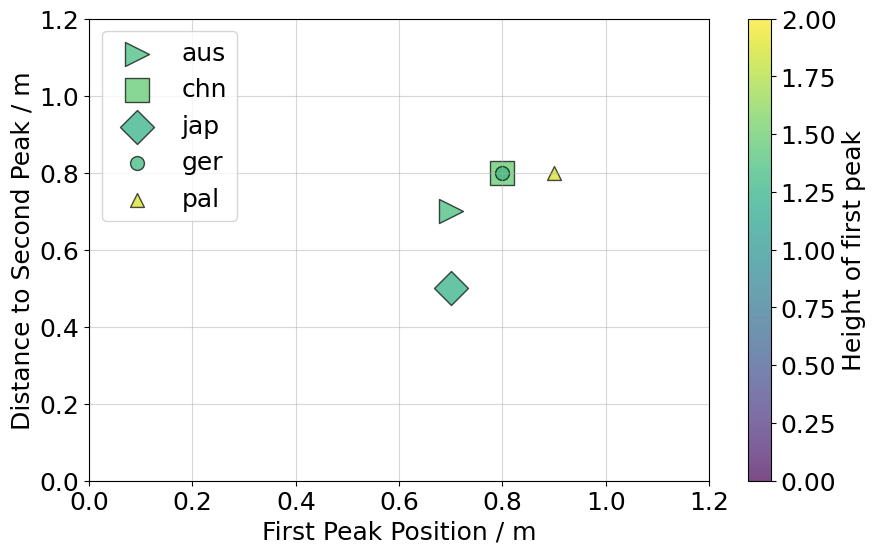

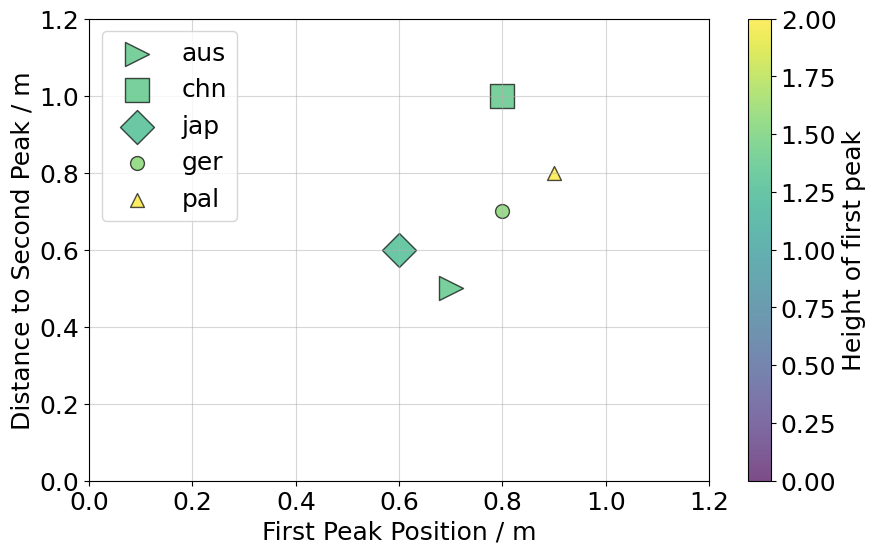

In [38]:
markers = ["o", "s", "^", "D", "+"]  # List of markers for different categories
markers = ["o", "s", "^", "D", "+"]
markers = [">", "s", "D", "o", "^"]
# Plot for each country
scatter_plots = []
first_height_min = df["first_height"].min()
first_height_max = df["first_height"].max()
unique_first_peaks = np.unique(df["first_peak"])
additional_ticks = [0, 0.2, 0.4, 0.6, 1.0, 1.2]
all_ticks = np.sort(np.unique(np.concatenate((unique_first_peaks, additional_ticks))))
for category in categories:
    plt.figure(figsize=(10, 6))
    for country, marker in zip(countries, markers):
        subset = df[(df["country"] == country) & (df["category"] == category)]
        #print(country, category, ">>",subset)
        if subset.empty or subset.isnull().values.any():
            continue
        if marker == "o" or marker == "^":
            mr_size = 100
        else:
            mr_size = 300
        scatter = plt.scatter(
            subset["first_peak"],
            subset["distance"],
            c=subset["first_height"],
            cmap="viridis",
            s=mr_size,
            label=country,
            marker=marker,
            facecolors="auto",
            edgecolors="black",
            alpha=0.7,
        )
        scatter.set_clim(0, 2)
        scatter_plots.append(scatter)
    cbar = plt.colorbar(scatter_plots[-1], label="First Height")
    cbar.set_label("Height of first peak", fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    # plt.title(f'First Peak vs Distance for {category}')
    plt.xlabel("First Peak Position / m", fontsize=18)
    plt.ylabel("Distance to Second Peak / m", fontsize=18)
    plt.legend(fontsize=18, loc="upper left")
    plt.grid(True, alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=18)
#    plt.xticks(all_ticks)
    plt.ylim([0, 1.2])
    plt.xlim([0, 1.2])

    if high_density:
        figname = f"category/pdf/first_peak_vs_distance_{category}_high.pdf"
    else:
        figname = f"category/pdf/first_peak_vs_distance_{category}_low.pdf"

    print(figname)
    plt.savefig(figname, dpi=300, bbox_inches="tight")

In [50]:
# TODO maybe for japan the average between 16 and 24
# Define categories
mixed_categories = ["mix_sorted", "mix_random"]
gender_categories = ["male", "female"]

# List of markers for countries
markers = ["D", "s", "^", "o", ">"]

# Plot for each group (mixed and gender)

first_height_min = df["first_height"].min()
first_height_max = df["first_height"].max()
unique_distances = np.unique(df["distance"])

unique_first_peaks = np.unique(df["first_peak"])
additional_ticks = [0, 0.2, 0.4, 0.6, 1.0, 1.2]
all_ticks_x = np.sort(np.unique(np.concatenate((unique_first_peaks, additional_ticks))))
all_ticks_x = all_ticks_x[~np.isnan(all_ticks_x)]


all_ticks_y = np.sort(np.unique(np.concatenate((unique_distances, additional_ticks))))
all_ticks_y = all_ticks_y[~np.isnan(all_ticks_y)]


# Function to generate plots for given categories
def plot_category(categories, plot_name, countries):
    plt.figure(figsize=(10, 6))
    scatter_plots = []
    print(countries)

    for category in categories:
        print(category)
        if category == "male":
            edgecolor = "orange"
        if category == "female":
            edgecolor = "lightblue"
        if category == "mix_random":
            edgecolor = "red"
        if category == "mix_sorted":
            edgecolor = "violet"
        for country, marker in zip(countries, markers):
            subset = df[(df["country"] == country) & (df["category"] == category)]
            if subset.empty or subset.isnull().values.any():
                continue
            if marker == "o" or marker == "^":
                mr_size = 100
            else:
                mr_size = 300

            if category == "male":
                label = f"Male ({country})"
            if category == "female":
                label = f"Female ({country})"

            if category == "mix_sorted":
                label = f"Mix sorted ({country})"
            if category == "mix_random":
                label = f"Mix random ({country})"

            scatter = plt.scatter(
                subset["first_peak"],
                subset["distance"],
                c=edgecolor,  # subset["first_height"],
                # cmap="viridis",
                s=mr_size,
                label=label,
                marker=marker,
                facecolors=edgecolor,
                edgecolors="black",
                alpha=0.7,
            )
            scatter.set_clim(0, 2)
            scatter_plots.append(scatter)

    # cbar = plt.colorbar(scatter_plots[-1], label="First Height")
    # cbar.set_label("Height of first peak", fontsize=18)
    # cbar.ax.tick_params(labelsize=18)
    plt.xlabel("First Peak Position / m", fontsize=18)
    plt.ylabel("Distance to Second Peak / m", fontsize=18)
    plt.legend(fontsize=18, loc="upper left")
    plt.xticks(all_ticks_x)
    plt.yticks(all_ticks_y)
    plt.grid(True, alpha=0.5)
    plt.tick_params(axis="both", which="major", labelsize=18)
    plt.ylim([0, 1.2])
    plt.xlim([0, 1.2])

    if high_density:
        figname = f"category/pdf/first_peak_vs_distance_{plot_name}_{plot_name}_high.pdf"
    else:
        figname = f"category/pdf/first_peak_vs_distance_{plot_name}_{plot_name}_low.pdf"

    print(figname)
    plt.savefig(figname, dpi=300, bbox_inches="tight")
    plt.close()


# Generate plots for gender categories (male and female)
plot_category(gender_categories, "MF", countries=countries)

countries_sorted = ["aus", "chn", "ger", "jap", "pal"]
# Generate plots for mixed categories (mix_random and mix_sorted)
plot_category(mixed_categories, "mixed", countries=countries_sorted)

['aus', 'chn', 'jap', 'ger', 'pal']
male
female
category/pdf/first_peak_vs_distance_MF_MF_low.pdf
['aus', 'chn', 'ger', 'jap', 'pal']
mix_sorted
mix_random
category/pdf/first_peak_vs_distance_mixed_mixed_low.pdf


In [40]:
df[df['category'].isin(gender_categories)]


,country,category,first_peak,first_height,distance
2,aus,male,0.7,1.358805,0.7
3,aus,female,0.7,1.387965,0.5
6,chn,male,0.8,1.471226,0.8
7,chn,female,0.8,1.386950,1.0
10,jap,male,0.7,1.248835,0.5
11,jap,female,0.6,1.278673,0.6
14,ger,male,0.8,1.325053,0.8
15,ger,female,0.8,1.562249,0.7
18,pal,male,0.9,1.867175,0.8
19,pal,female,0.9,2.004945,0.8
